In [1]:
# packages
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from scipy.stats import shapiro, kruskal
import scikit_posthocs as sp


## Combine Files from Folder: Distance Analysis
This script combines distance matrices from multiple Excel files in a specified folder.
It reads the first two rows of each file, drops the first column, transposes the data,
and appends the 'Well' information extracted from the filename to each row.
The combined data is then saved to a new Excel file.


In [2]:
"""This script combines distance matrices from multiple Excel files in a specified folder.
Each file should contain a distance matrix with the first two rows representing segments and their values."""

def combine_distance_matrices(folder_path):
    """
    Combine distance matrices from multiple Excel files in a specified folder.
    """
    combined_data = []

    # Iterate through all files in the specified folder
    for filename in os.listdir(folder_path):
        # Only process Excel files that contain 'DistanceMatrix' in their name
        if filename.endswith(".xlsx") and "DistanceMatrix" in filename:
            try:
                # Extract the 'Well' identifier from the filename (assumes it's the second part)
                well = filename.split('_')[1]
                file_path = os.path.join(folder_path, filename)

                # Read only the first two rows (since that's where the data is)
                df = pd.read_excel(file_path, engine='openpyxl', header=None, nrows=2)

                # Drop the first column (usually an index or label column)
                df = df.iloc[:, 1:]

                # Transpose the DataFrame so that each segment/value pair is a row
                transposed = df.transpose()
                transposed.columns = ['Segment', 'Value']
                transposed['Well'] = well

                # Add the processed DataFrame to our list
                combined_data.append(transposed)

            except Exception as e:
                # Print an error message if something goes wrong with this file
                print(f"Failed to process {filename}: {e}")

    # Concatenate all the individual DataFrames into one
    if combined_data:
        result_df = pd.concat(combined_data, ignore_index=True)
        result_df = result_df[['Well', 'Segment', 'Value']]
        return result_df
    else:
        # If no valid files were found, return an empty DataFrame with the correct columns
        print("No valid files found.")
        return pd.DataFrame(columns=['Well', 'Segment', 'Value'])

# Main script: set folder and output paths, run the combine function, and save the result

folder_path = r"\\143.169.22.56\SparkCytoData\PLASMANT\Cecilia\APM_GJ_BxPC3_rep1_04_02_25\Arivis\07052025 APM"  # Update this to your actual path
output_path = os.path.join(folder_path, "combined_distance_matrix.xlsx")
print(f"Combining distance matrices from: {folder_path}")
print(f"Output will be saved to: {output_path}")
combined_df = combine_distance_matrices(folder_path)
combined_df.to_excel(output_path, index=False)
print(f"Combined file saved to: {output_path}")

Combining distance matrices from: \\143.169.22.56\SparkCytoData\PLASMANT\Cecilia\APM_GJ_BxPC3_rep1_04_02_25\Arivis\07052025 APM
Output will be saved to: \\143.169.22.56\SparkCytoData\PLASMANT\Cecilia\APM_GJ_BxPC3_rep1_04_02_25\Arivis\07052025 APM\combined_distance_matrix.xlsx
Failed to process GapJunction_18__GapJunction-DistanceMatrix.xlsx: Length mismatch: Expected axis has 0 elements, new values have 2 elements
Failed to process GapJunction_19__GapJunction-DistanceMatrix.xlsx: Length mismatch: Expected axis has 0 elements, new values have 2 elements
Failed to process GapJunction_20__GapJunction-DistanceMatrix.xlsx: Length mismatch: Expected axis has 0 elements, new values have 2 elements
Combined file saved to: \\143.169.22.56\SparkCytoData\PLASMANT\Cecilia\APM_GJ_BxPC3_rep1_04_02_25\Arivis\07052025 APM\combined_distance_matrix.xlsx


## Classification of LY distance results 
Only LY+ cells located within 150 um from the edge of the wound will be counted, then classified based on the treatment condition.
The filtered results are then stored in another Excel file


In [3]:
## Command to sort out results from 0-150 um, grouped by treatment

""" This section filters the combined DataFrame to keep only values between 0 and 150, and assigns group labels based on 'Well' """

# Filter the combined DataFrame to keep only values between 0 and 150, and assign group labels based on 'Well'
# Use the already loaded combined_df
df = combined_df.copy()

# Convert Value to numeric (if not already)
df['Value'] = pd.to_numeric(df['Value'], errors='coerce')

# Remove all negative values
df = df[df['Value'] >= 0]
# Remove all values > 150
df = df[df['Value'] <= 150]

# Convert Well to integer if possible
df['Well'] = pd.to_numeric(df['Well'], errors='coerce')

# Remove rows where Well could not be converted
df = df.dropna(subset=['Well'])

# Make sure 'Well' is treated as integer
df['Well'] = df['Well'].astype(int)

# Assign a group number: every 3 wells (because 3 wells per repeat x 2 repeats) will be in the same group
df['Well_Group'] = (df['Well'] // 3) * 7  # Groups: 0, 7, 14, etc.

# Define your custom labels for each group
group_label_map = {
    0: "UT",
    7: "DBD",
    14: "H2O2",
    21: "Doxo",
    28: "SNAP",
    35: "FA",
    42: "DTT",
}
# Map numeric group to your custom label
df['Well_Group_Label'] = df['Well_Group'].map(group_label_map)

plt.show()

# Save the results to Excel in the same folder as the input files
output_path = os.path.join(folder_path, "filtered_distance_matrix_results.xlsx")
df.to_excel(output_path, index=False)
print(f"Results saved to: {output_path}")

# Summary of the script:
# - The script combines distance matrices from multiple Excel files in a specified folder.
# - Data is filtered and grouped efficiently using pandas vectorized operations.
# - Grouping logic is clear and uses integer division for mapping wells to treatments.
# - Mapping group numbers to human-readable labels improves downstream analysis and plotting.
# - Data is exported for reproducibility and further use.


Results saved to: \\143.169.22.56\SparkCytoData\PLASMANT\Cecilia\APM_GJ_BxPC3_rep1_04_02_25\Arivis\07052025 APM\filtered_distance_matrix_results.xlsx


## Plotting of Distance results: create a heatmap from filtered results obtained in the previous cell
This script creates a heatmap from the filtered distance matrix results.
It bins the 'Value' column into specified ranges (steps of 10) and counts occurrences for each 'Well_Group_Label'.

Figure saved to: \\143.169.22.56\SparkCytoData\PLASMANT\Cecilia\APM_GJ_HT29_rep3_BxPC3_rep2_rep3_12_03_25\Arivis\BxPC3\Results\BxPC3_123_distance_heatmap.png


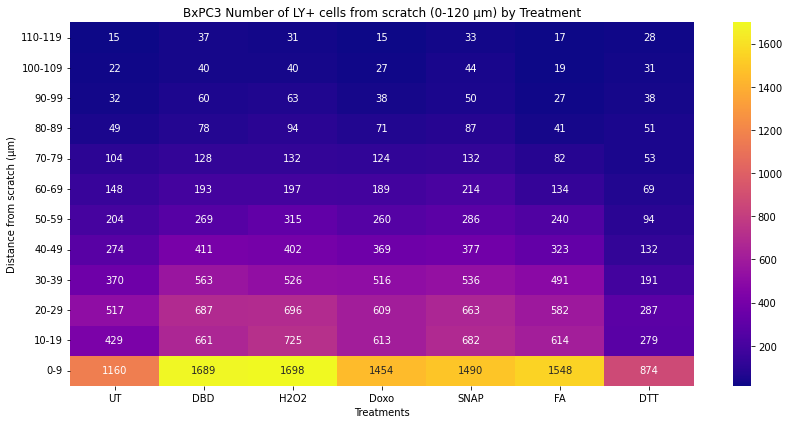

In [4]:
"""This script combines distance matrices from multiple Excel files in a specified folder.
Each file should contain a distance matrix with the first two rows representing segments and their values."""

# Define folder and file path
folder_path = r"\\143.169.22.56\SparkCytoData\PLASMANT\Cecilia\APM_GJ_HT29_rep3_BxPC3_rep2_rep3_12_03_25\Arivis\BxPC3\Results"  # Update if needed
results_file = os.path.join(folder_path, "filtered_distance_matrix_results1,2,3.xlsx")

# Load data
df = pd.read_excel(results_file, engine='openpyxl')

# Convert Value to numeric (if not already)
df['Value'] = pd.to_numeric(df['Value'], errors='coerce')

# Bin the Value column (0-150, e.g., in steps of 10)
bins = list(range(0, 121, 10))
labels = [f"{i}-{i+9}" for i in bins[:-1]]
df['Value_bin'] = pd.cut(df['Value'], bins=bins, labels=labels, include_lowest=True)

# Create a pivot table: rows=Well_Group_Label, columns=Value_bin, values=count
heatmap_data = df.pivot_table(columns='Well_Group_Label', index='Value_bin', values='Value', aggfunc='count', fill_value=0)

# Desired column order
desired_order = ["UT", "DBD", "H2O2", "Doxo", "SNAP", "FA", "DTT"]

# Reindex columns to desired order (missing columns will be filled with 0)
heatmap_data = heatmap_data.reindex(columns=desired_order, fill_value=0)

# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap="plasma", annot=True, fmt="d")
plt.title("BxPC3 Number of LY+ cells from scratch (0-120 µm) by Treatment")
plt.xlabel("Treatments")
plt.ylabel("Distance from scratch (µm)")
plt.tight_layout()
plt.gca().invert_yaxis()  # Invert the Y axis

# Save figure (in the same folder as your data)
figure_path = os.path.join(folder_path, "BxPC3_123_distance_heatmap.png")
plt.savefig(figure_path, dpi=500)
print(f"Figure saved to: {figure_path}")

plt.show()

## Combine GJ Green area files and make barplot 
This script processes multiple Excel files in a specified folder, extracts GJ Green Area and Intersect Area data, and combines the results into a single DataFrame. The final DataFrame is saved to an Excel file.
It also generates a barplot showing the Mean + SD


Saved combined results to: \\143.169.22.56\SparkCytoData\PLASMANT\Cecilia\APM_GJ_BxPC3_rep1_04_02_25\Arivis\07052025 APM\combined_green_area_results.xlsx
Unique types in 'Sum Green Area (corrected)': [<class 'float'>]
Non-numeric rows:
Empty DataFrame
Columns: [Well_Group_Label, Sum Green Area (corrected)]
Index: []
Dtype after conversion: float64


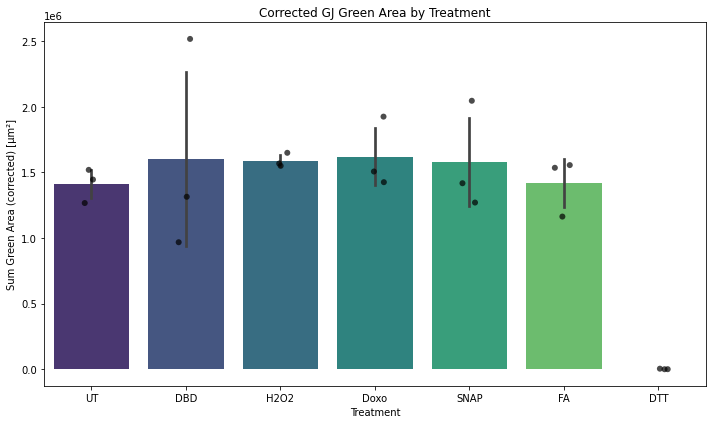

In [ ]:
"""This script processes multiple Excel files containing GJ Green Area and Intersect Area data, calculates the corrected green area, groups wells by treatment, and visualizes the results using a bar plot and strip plot.
"""

# Define folder containing the files
folder_path = r"\\143.169.22.56\SparkCytoData\PLASMANT\Cecilia\APM_GJ_BxPC3_rep1_04_02_25\Arivis\07052025 APM" # <-- Update this to your folder path

# Find all Excel files containing 'objectfeatures' in the filename
file_paths = glob(os.path.join(folder_path, "*objectfeatures*.xlsx"))

# Initialize list to collect individual result DataFrames
all_results = []

# Define your custom labels
group_label_map = {
    0: "UT",
    7: "DBD",
    14: "H2O2",
    21: "Doxo",
    28: "SNAP",
    35: "FA",
    42: "DTT",
}

# Process each file
for file_path in file_paths:
    try:
        df_green = pd.read_excel(file_path, engine='openpyxl')

        # Filter Green Area
        green_area_df = df_green[df_green['Name'].str.contains('GJ Green area', na=False)]
        green_area_df = green_area_df[~green_area_df['Name'].str.contains('Intersect', na=False)]
        green_area_sum = green_area_df['Area, 2D Oriented Bounds (µm²)'].sum()

        # Filter Intersect Area
        intersect_area_df = df_green[df_green['Name'].str.contains('Intersect', na=False)]
        intersect_area_sum = intersect_area_df['Area, 2D Oriented Bounds (µm²)'].sum()

        # Subtract intersect area from green area
        green_area_corrected = green_area_sum - intersect_area_sum

        # Extract well name/number from file name
        well_name = os.path.basename(file_path).split('_')[1]  # Assuming well name is the second part of the filename
        try:
            well_num = int(well_name)
        except ValueError:
            well_num = None

        if well_num is not None:
            well_group = (well_num // 3) * 7
            well_group_label = group_label_map.get(well_group, str(well_group))
        else:
            well_group = None
            well_group_label = None
            
        # Create result DataFrame
        df_results = pd.DataFrame({
            'Well': [well_name],
            'Well_Group': [well_group],
            'Well_Group_Label': [well_group_label],
            'Sum Green Area': [green_area_sum],
            'Sum Intersect Area': [intersect_area_sum],
            'Sum Green Area (corrected)': [green_area_corrected]
        })

        all_results.append(df_results)
    except Exception as e:
        print(f"Failed to process {file_path}: {e}")

# Combine all results into a single DataFrame
combined_results = pd.concat(all_results, ignore_index=True)

# Save to Excel
output_file = os.path.join(folder_path, "combined_green_area_results.xlsx")
combined_results.to_excel(output_file, index=False)

print(f"Saved combined results to: {output_file}")

# Show all unique types in the column
print("Unique types in 'Sum Green Area (corrected)':", combined_results['Sum Green Area (corrected)'].apply(type).unique())

# Show all non-numeric values (if any)
non_numeric = combined_results[~combined_results['Sum Green Area (corrected)'].apply(lambda x: isinstance(x, (int, float)))]
print("Non-numeric rows:")
print(non_numeric[['Well_Group_Label', 'Sum Green Area (corrected)']])

#Plotting the results

# Clean column names
combined_results.columns = combined_results.columns.str.strip()

# Remove rows with missing group labels or values
combined_results = combined_results[combined_results['Well_Group_Label'].notna()]

# Force conversion to numeric, drop all non-numeric
combined_results['Sum Green Area (corrected)'] = pd.to_numeric(
    combined_results['Sum Green Area (corrected)'], errors='coerce'
)
combined_results = combined_results.dropna(subset=['Sum Green Area (corrected)'])

# Confirm dtype is now float
print("Dtype after conversion:", combined_results['Sum Green Area (corrected)'].dtype)

# Specify the desired order of treatments
order = ["UT", "DBD", "H2O2", "Doxo", "SNAP", "FA", "DTT"]

# Barplot of Sum Green Area (corrected) by Well_Group_Label
plt.figure(figsize=(10, 6))
sns.barplot(
    data=combined_results,
    x='Well_Group_Label',
    y='Sum Green Area (corrected)',
    ci='sd',
    palette='viridis',
    order=order  # Specify the order here
)

sns.stripplot(
    data=combined_results,
    x='Well_Group_Label',
    y='Sum Green Area (corrected)',
    color='black',
    size=6,
    order=order,
    jitter=True,
    dodge=True,
    alpha=0.7
)
plt.title('Corrected GJ Green Area by Treatment')
plt.xlabel('Treatment')
plt.ylabel('Sum Green Area (corrected) [µm²]')
plt.tight_layout()
plt.show()

## Plotting LY+ area - statistical analysis
This code makes a barplot of the combined results, removes outliers, test for normality of the data and runs the most appropiate statistical analysis



DBD: 1 outlier(s) removed. Values: [2933616.60863506]
Doxo: 2 outlier(s) removed. Values: [2120592.74818901  981221.24582546]
FA: 1 outlier(s) removed. Values: [3063738.41869574]
H2O2: 1 outlier(s) removed. Values: [2566204.49189066]
SNAP: 1 outlier(s) removed. Values: [2909800.67752574]


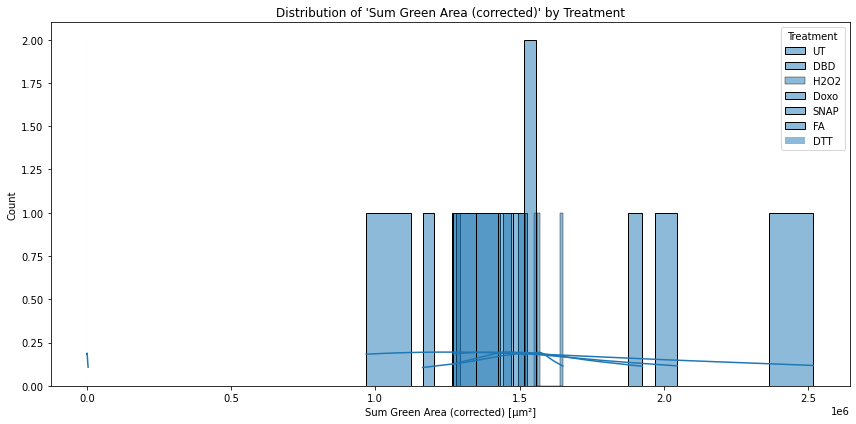

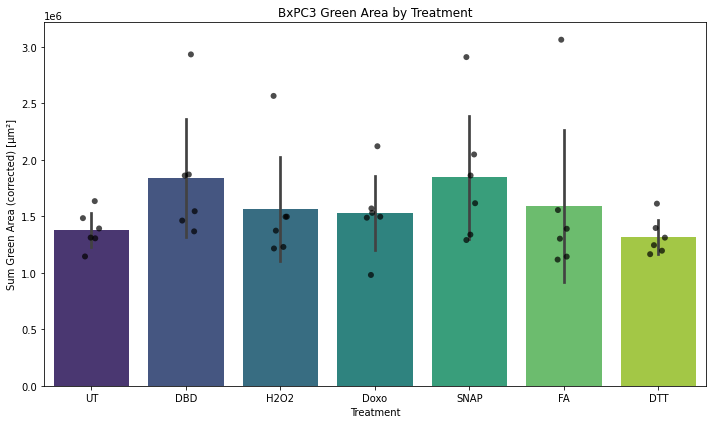

UT: Shapiro-Wilk p-value = 0.5127 (n=6)
DBD: Shapiro-Wilk p-value = 0.0457 (n=6)
H2O2: Shapiro-Wilk p-value = 0.0562 (n=6)
Doxo: Shapiro-Wilk p-value = 0.3463 (n=6)
SNAP: Shapiro-Wilk p-value = 0.6407 (n=6)
FA: Shapiro-Wilk p-value = 0.0205 (n=6)
DTT: Shapiro-Wilk p-value = 0.5467 (n=6)

Kruskal-Wallis H-statistic: 12.3411
p-value: 5.4778e-02
No statistically significant difference detected between groups.

Pairwise Dunn's test p-values vs UT:
DBD vs UT: p = 7.4016e-02
H2O2 vs UT: p = 6.3837e-01
Doxo vs UT: p = 1.0000e+00
SNAP vs UT: p = 1.5344e-01
FA vs UT: p = 1.0000e+00
DTT vs UT: p = 1.0000e+00


In [13]:

# Load the data
file_path = r"\\143.169.22.56\SparkCytoData\PLASMANT\Cecilia\APM_GJ_HT29_rep3_BxPC3_rep2_rep3_12_03_25\Arivis\BxPC3\Results\combined_green_area_results2,3.xlsx"
df = pd.read_excel(file_path, engine='openpyxl')

# Clean column names
df.columns = df.columns.str.strip()

# Remove rows with missing group labels or values
df = df[df['Well_Group_Label'].notna()]

# Convert to numeric, drop non-numeric
df['Sum Green Area (corrected)'] = pd.to_numeric(df['Sum Green Area (corrected)'], errors='coerce')
df = df.dropna(subset=['Sum Green Area (corrected)'])

# Specify the desired order of treatments (edit as needed)
order = ["UT", "DBD", "H2O2", "Doxo", "SNAP", "FA", "DTT"]

# --- Outlier detection and removal (IQR method) ---
def remove_outliers_iqr(df, value_col, group_col):
    df_clean = pd.DataFrame()
    for label in df[group_col].unique():
        group = df[df[group_col] == label]
        if len(group) > 0:
            Q1 = group[value_col].quantile(0.25)
            Q3 = group[value_col].quantile(0.75)
            IQR = Q3 - Q1
            lower = Q1 - 1.5 * IQR
            upper = Q3 + 1.5 * IQR
            outliers = group[(group[value_col] < lower) | (group[value_col] > upper)]
            if not outliers.empty:
                print(f"{label}: {len(outliers)} outlier(s) removed. Values: {outliers[value_col].values}")
            group_no_outliers = group[(group[value_col] >= lower) & (group[value_col] <= upper)]
            df_clean = pd.concat([df_clean, group_no_outliers], ignore_index=True)
        else:
            print(f"{label}: No data.")
    return df_clean

# Remove outliers from df_total_green
df_no_outliers = remove_outliers_iqr(
    df, value_col='Sum Green Area', group_col='Well_Group_Label'
)
# Plot histogram and KDE for each group
plt.figure(figsize=(12, 6))
for label in order:
    group_data = combined_results[combined_results['Well_Group_Label'] == label]['Sum Green Area (corrected)']
    if not group_data.empty:
        sns.histplot(group_data, kde=True, label=label, alpha=0.5, bins=10)
plt.legend(title="Treatment")
plt.title("Distribution of 'Sum Green Area (corrected)' by Treatment")
plt.xlabel("Sum Green Area (corrected) [µm²]")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    data=df,
    x='Well_Group_Label',
    y='Sum Green Area',
    ci='sd',
    palette='viridis',
    order=order  # Remove this line if you want automatic order
)
sns.stripplot(
    data=df,
    x='Well_Group_Label',
    y='Sum Green Area',
    color='black',
    size=6,
    order=order,
    jitter=True,
    dodge=True,
    alpha=0.7
)
plt.title('BxPC3 Green Area by Treatment')
plt.xlabel('Treatment')
plt.ylabel('Sum Green Area (corrected) [µm²]')
plt.tight_layout()
plt.show()

from scipy.stats import shapiro, kruskal

# Shapiro-Wilk test for normality per group
# -- Classic normality test, but only valid for n > 2. Useful for deciding between parametric/non-parametric stats.
for label in order:
    group_data = df[df['Well_Group_Label'] == label]['Sum Green Area (corrected)']
    if len(group_data) > 2:
        stat, p = shapiro(group_data)
        print(f"{label}: Shapiro-Wilk p-value = {p:.4f} (n={len(group_data)})")
    else:
        print(f"{label}: Not enough data for Shapiro-Wilk test (n={len(group_data)})")

# Kruskal-Wallis test (non-parametric ANOVA)
group_data = [df[df['Well_Group_Label'] == label]['Sum Green Area (corrected)'].values for label in order]
group_data_filtered = [g for g in group_data if len(g) > 2]
labels_filtered = [label for g, label in zip(group_data, order) if len(g) > 2]

if len(group_data_filtered) > 1:
    stat, p = kruskal(*group_data_filtered)
    print(f"\nKruskal-Wallis H-statistic: {stat:.4f}")
    print(f"p-value: {p:.4e}")
    if p < 0.05:
        print("Statistically significant difference between at least two groups.")
    else:
        print("No statistically significant difference detected between groups.")
else:
    print("Not enough groups with sufficient data for Kruskal-Wallis test.")

# Only keep groups present in your data and with at least 3 values
valid_labels = [label for label in order if len(df[df['Well_Group_Label'] == label]) > 2]
filtered = df[df['Well_Group_Label'].isin(valid_labels)]

# Dunn's test (pairwise, Bonferroni correction)
dunn_results = sp.posthoc_dunn(
    filtered,
    val_col='Sum Green Area (corrected)',
    group_col='Well_Group_Label',
    p_adjust='bonferroni'
)

# Print p-values for each group vs UT
print("\nPairwise Dunn's test p-values vs UT:")
for label in valid_labels:
    if label != "UT":
        try:
            pval = dunn_results.loc[label, "UT"]
        except KeyError:
            pval = dunn_results.loc["UT", label]
        print(f"{label} vs UT: p = {pval:.4e}")
